In this notebook, we visualise the data for both raw and normalised cases. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
# Path_raw = '../../data/Results_Microplate_normFalse_formatSeq_logTrue.csv'
# Path_normalised = '../../data/Results_Microplate_normTrue_plateRep_formatSeq_logTrue.csv'

Path_raw = '../../data/Results_Microplate_partialFalse_normFalse_formatSeq_logTrue.csv'
Path_normalised = '../../data/Results_Microplate_partialFalse_normTrue_roundRep_formatSeq_logTrue.csv'

df_raw = pd.read_csv(Path_raw)
df_normalised = pd.read_csv(Path_normalised)

In [3]:
df_raw

,Unnamed: 0,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,Rep7,Rep8,Rep9,AVERAGE,STD
0,0,RBS_1by1_0,reference,First_Plate,0,TTTAAGAAGGAGATATACAT,AGGAGA,80.919700,52.402431,98.720440,61.622165,54.151485,45.499195,NaN,NaN,NaN,65.552569,18.514648
1,1,RBS_1by1_1,bps_noncore,First_Plate,0,CTTAAGAAGGAGATATACAT,AGGAGA,58.336880,40.072951,81.136200,42.042854,45.432032,41.005659,NaN,NaN,NaN,51.337763,14.673422
2,2,RBS_1by1_2,bps_noncore,First_Plate,0,GTTAAGAAGGAGATATACAT,AGGAGA,38.780700,28.831559,58.763330,24.487870,24.133637,25.596639,NaN,NaN,NaN,33.432289,12.378064
3,3,RBS_1by1_3,bps_noncore,First_Plate,0,ATTAAGAAGGAGATATACAT,AGGAGA,60.720820,43.093359,74.605290,38.641958,38.049577,31.608154,NaN,NaN,NaN,47.786526,14.992992
4,4,RBS_1by1_4,bps_noncore,First_Plate,0,TCTAAGAAGGAGATATACAT,AGGAGA,58.099540,45.913214,70.531620,44.352931,38.394865,43.641794,NaN,NaN,NaN,50.155661,10.883487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,265,RBS_BA_1658,bandit2,Third_Plate,1,TTTAAGAGCTAAGTATACAT,GCTAAG,18.032699,15.510597,19.025742,49.556048,55.543099,51.343166,35.905191,NaN,NaN,34.835225,17.434337
262,266,RBS_BA_1548,bandit2,Third_Plate,1,TTTAAGAGCGGAGTATACAT,GCGGAG,30.783891,29.832041,29.059445,63.605031,73.146660,70.408885,51.316625,NaN,NaN,49.472659,19.791543
263,267,RBS_BA_2887,bandit2,Third_Plate,1,TTTAAGACTCTACTATACAT,CTCTAC,16.428919,16.141052,13.846184,45.631922,53.535583,49.018156,34.505612,NaN,NaN,32.433636,17.134886
264,268,RBS_BA_3330,bandit2,Third_Plate,1,TTTAAGATGGTTATATACAT,TGGTTA,17.777483,17.799044,18.383063,46.936247,58.773355,48.436283,37.206173,NaN,NaN,34.684246,17.108441


In [4]:
df_normalised

,Unnamed: 0,Name,Group,Plate,Round,RBS,RBS6,Rep1,Rep2,Rep3,...,Rep5,Rep6,Rep7,Rep8,Rep9,AVERAGE,STD,Pred Mean,Pred Std,Pred UCB
0,0,RBS_1by1_0,reference,First_Plate,0,TTTAAGAAGGAGATATACAT,AGGAGA,2.433056,2.502155,2.315237,...,2.917124,2.275329,NaN,NaN,NaN,2.575968,0.313540,NaN,NaN,NaN
1,1,RBS_1by1_1,bps_noncore,First_Plate,0,CTTAAGAAGGAGATATACAT,AGGAGA,1.556251,1.654243,1.762146,...,2.312790,1.959275,NaN,NaN,NaN,1.839138,0.268820,NaN,NaN,NaN
2,2,RBS_1by1_2,bps_noncore,First_Plate,0,GTTAAGAAGGAGATATACAT,AGGAGA,0.603551,0.748674,0.921939,...,0.503846,0.711231,NaN,NaN,NaN,0.646754,0.188587,NaN,NaN,NaN
3,3,RBS_1by1_3,bps_noncore,First_Plate,0,ATTAAGAAGGAGATATACAT,AGGAGA,1.658359,1.874275,1.534988,...,1.747116,1.232548,NaN,NaN,NaN,1.598899,0.220191,NaN,NaN,NaN
4,4,RBS_1by1_4,bps_noncore,First_Plate,0,TCTAAGAAGGAGATATACAT,AGGAGA,1.545942,2.072095,1.386300,...,1.774833,2.146898,NaN,NaN,NaN,1.812638,0.300722,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,261,RBS_BA_1658,bandit2,Third_Plate,1,TTTAAGAGCTAAGTATACAT,GCTAAG,0.710566,0.329651,0.739814,...,0.984787,1.027128,0.722992,NaN,NaN,0.784134,0.256830,0.677239,0.634139,1.945517
262,262,RBS_BA_1548,bandit2,Third_Plate,1,TTTAAGAGCGGAGTATACAT,GCGGAG,2.371112,2.130169,1.840573,...,1.519450,1.684631,1.469772,NaN,NaN,1.824837,0.369508,0.789158,0.576882,1.942922
263,263,RBS_BA_2887,bandit2,Third_Plate,1,TTTAAGACTCTACTATACAT,CTCTAC,0.472520,0.419643,0.084277,...,0.917125,0.936878,0.647006,NaN,NaN,0.598548,0.333065,0.813209,0.564510,1.942230
264,264,RBS_BA_3330,bandit2,Third_Plate,1,TTTAAGATGGTTATATACAT,TGGTTA,0.673195,0.650845,0.662154,...,1.090485,0.913889,0.792242,NaN,NaN,0.800462,0.175970,0.706033,0.617109,1.940251


## AVERAGE Label Histogram

Text(0.5, 1.0, 'Normalised Average Label')

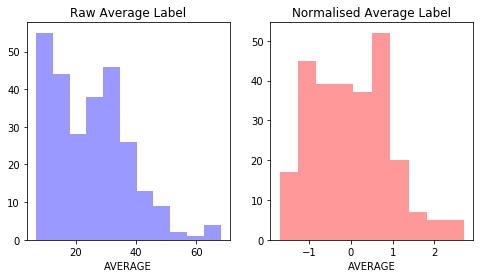

In [5]:
f, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=False)


sns.distplot(df_raw['AVERAGE'], kde=False, color="b", ax=axes[0])
axes[0].set_title('Raw Average Label')
sns.distplot(df_normalised['AVERAGE'], kde=False, color="r", ax=axes[1])
axes[1].set_title('Normalised Average Label')

## Replicates Distributions

Sorted by the average labels. x-axis represents sequences index with increasing average labels.

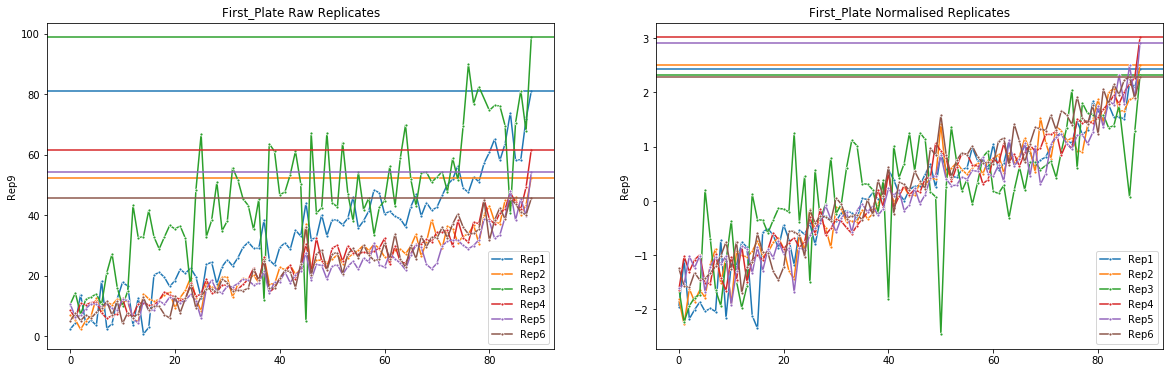

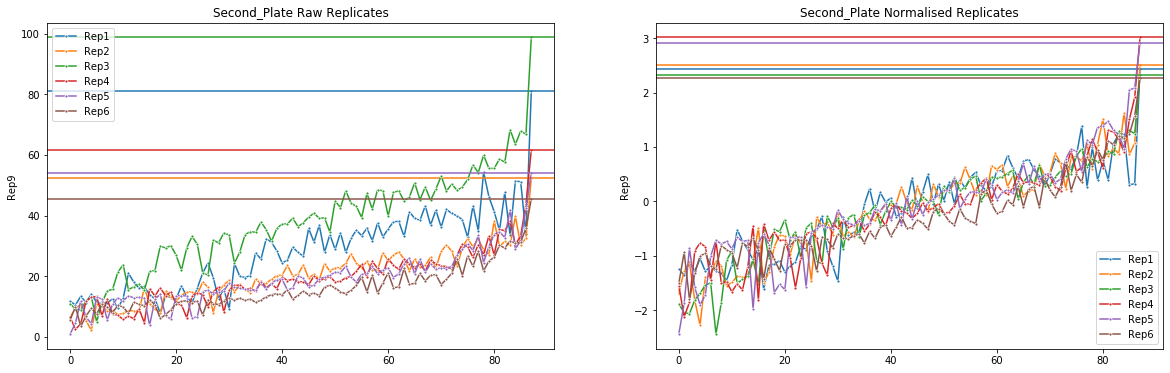

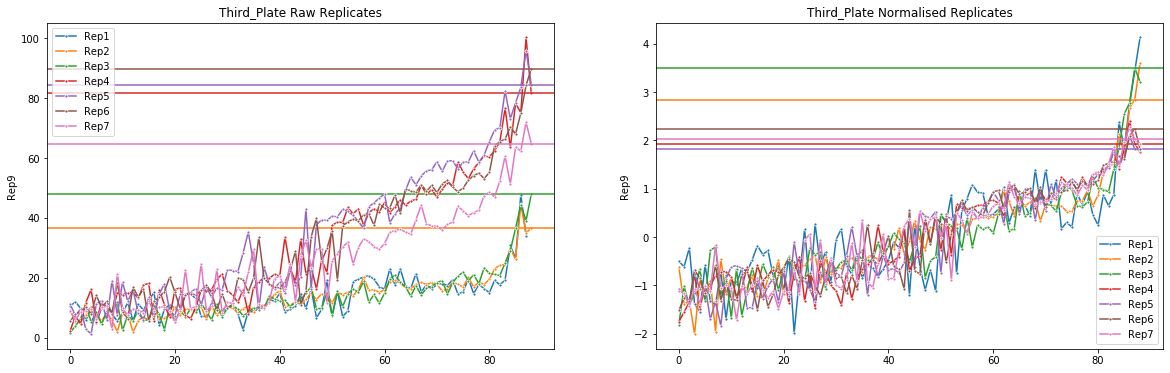

In [6]:
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')

for plate_name in ['First_Plate', 'Second_Plate', 'Third_Plate']:
    df_raw_plate = df_raw[df_raw['Plate'] == plate_name]
    df_normalised_plate = df_normalised[df_normalised['Plate'] == plate_name]

    sorted_by_ave_df_raw = df_raw_plate.sort_values(by = ['AVERAGE'])
    sorted_by_ave_df_normalised = df_normalised_plate.sort_values(by = ['AVERAGE'])

    f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

    for idx, i in enumerate(['Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6','Rep7', 'Rep8', 'Rep9']):
        sns.lineplot(range(len(sorted_by_ave_df_raw[i])), sorted_by_ave_df_raw[i], label = str(i), marker = '.', ax = axes[0], color = sns.color_palette("tab10")[idx])
        # print(sorted_by_ave_df_raw[sorted_by_ave_df_raw['Name'] == 'RBS_1by1_0'])
        # print(float(sorted_by_ave_df_raw[sorted_by_ave_df_raw['Name'] == 'RBS_1by1_0'][i]))
        axes[0].axhline(float(sorted_by_ave_df_raw[sorted_by_ave_df_raw['Name'] == 'RBS_1by1_0'][i]), color = sns.color_palette("tab10")[idx])
        sns.lineplot(range(len(sorted_by_ave_df_normalised[i])), sorted_by_ave_df_normalised[i], label = str(i), marker = '.', ax = axes[1], color = sns.color_palette("tab10")[idx])
        axes[1].axhline(float(sorted_by_ave_df_normalised[sorted_by_ave_df_normalised['Name'] == 'RBS_1by1_0'][i]), color = sns.color_palette("tab10")[idx])
    axes[0].set_title(plate_name + ' Raw Replicates')
    axes[1].set_title(plate_name + ' Normalised Replicates')

    plt.show()

Note the Z-score normalisation is in terms of each replicates, so if we sort each replicate and plot it, each replicates would like the similar, but note in this case, the x-axis does not represent the SAME sequence for each replicate.

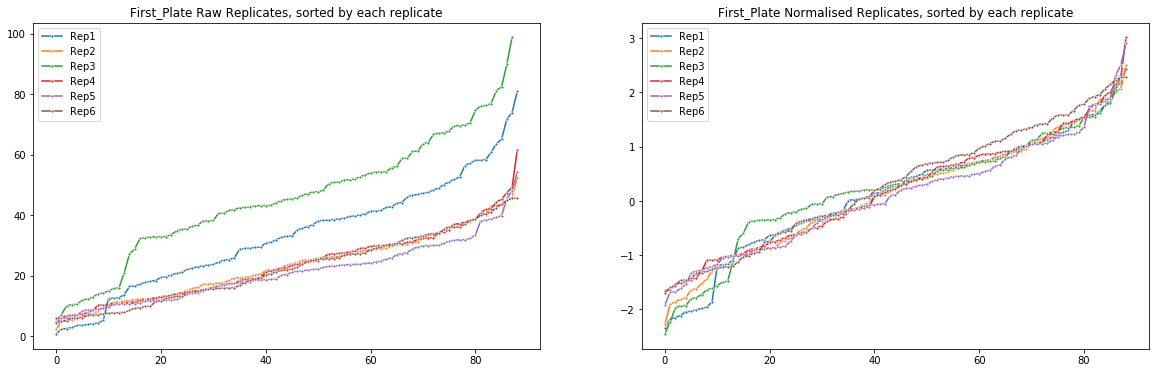

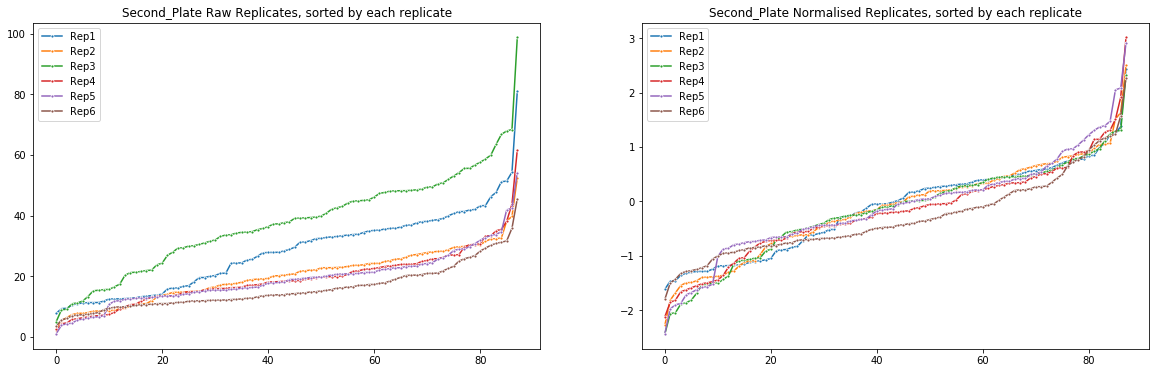

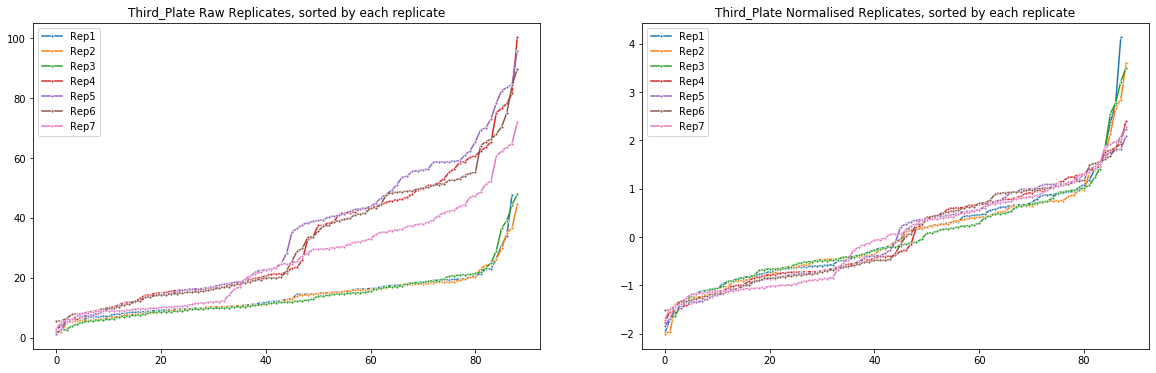

In [7]:
for plate_name in ['First_Plate', 'Second_Plate', 'Third_Plate']:
    df_raw_plate = df_raw[df_raw['Plate'] == plate_name]
    df_normalised_plate = df_normalised[df_normalised['Plate'] == plate_name]

    f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

    for i in ['Rep1', 'Rep2', 'Rep3', 'Rep4', 'Rep5', 'Rep6','Rep7', 'Rep8', 'Rep9',]:
        sns.lineplot(range(len(df_raw_plate[i])), np.sort(df_raw_plate[i]), label = str(i), marker = '.', ax = axes[0])
        sns.lineplot(range(len(df_normalised_plate[i])), np.sort(df_normalised_plate[i]), label = str(i), marker = '.', ax = axes[1])
    axes[0].set_title(plate_name + ' Raw Replicates, sorted by each replicate')
    axes[1].set_title(plate_name + ' Normalised Replicates, sorted by each replicate')

## Violinplot

Text(0.5, 1.0, 'Normalised')

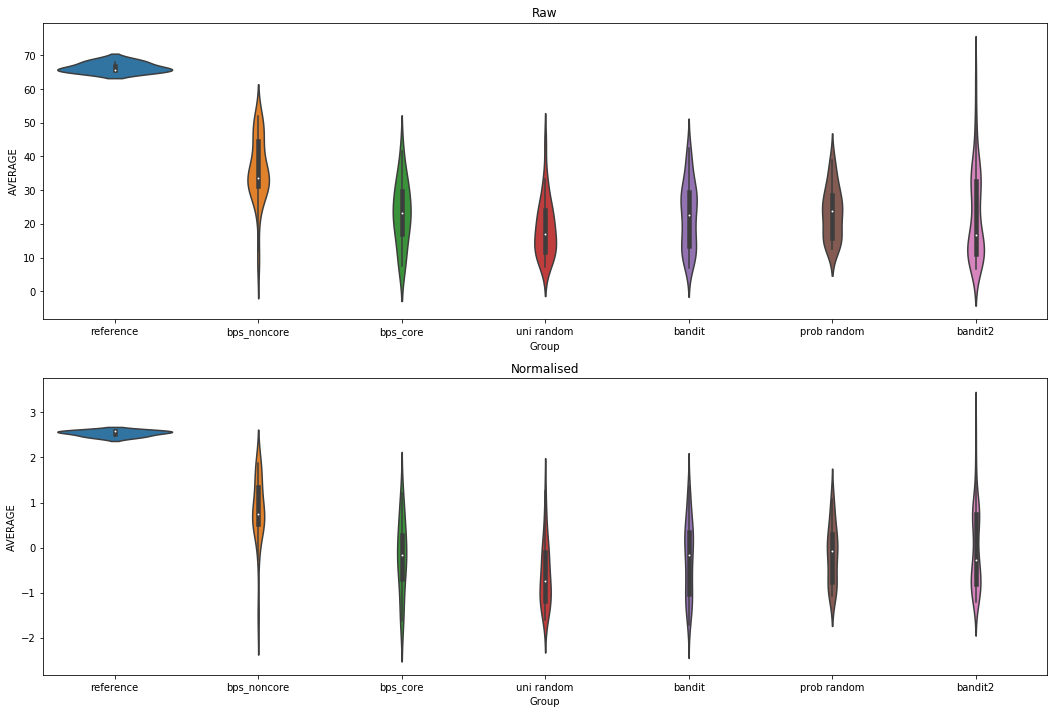

In [8]:
f, axes = plt.subplots(2, 1, figsize=(18,12), sharex=False)

sns.violinplot(x = 'Group', y = 'AVERAGE', data = df_raw, ax = axes[0])
sns.violinplot(x = 'Group', y = 'AVERAGE', data = df_normalised, ax = axes[1])
axes[0].set_title('Raw')
axes[1].set_title('Normalised')

Text(0.5, 1.0, 'Normalised')

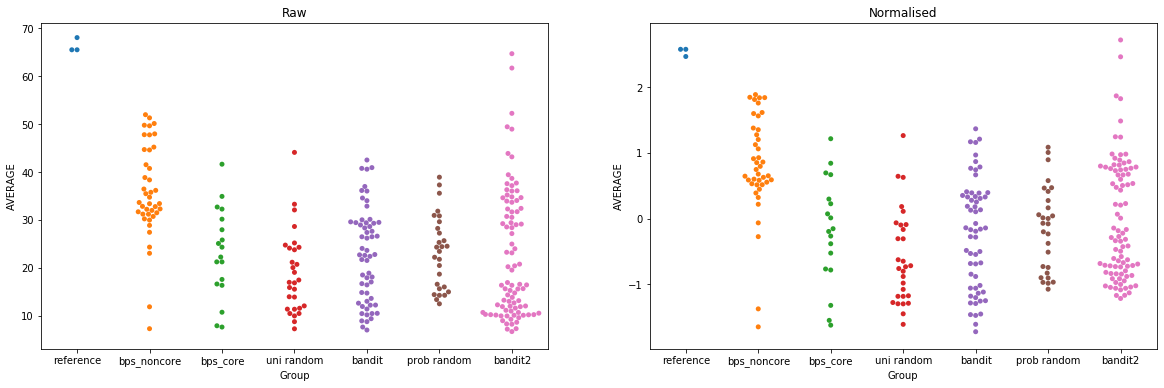

In [9]:
f, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_raw, ax = axes[0])
sns.swarmplot(x = 'Group', y = 'AVERAGE', data = df_normalised, ax = axes[1])
axes[0].set_title('Raw')
axes[1].set_title('Normalised')

## AVERAGE VS. Predictions

In [10]:
df_bandit2 = df_normalised[df_normalised['Group'] == 'bandit2']
df_bandit2['Pred Mean']

177    1.148037
178    0.993331
179    0.942982
180    1.000676
181    1.022734
         ...   
260    0.558830
261    0.677239
262    0.789158
263    0.813209
264    0.706033
Name: Pred Mean, Length: 88, dtype: float64

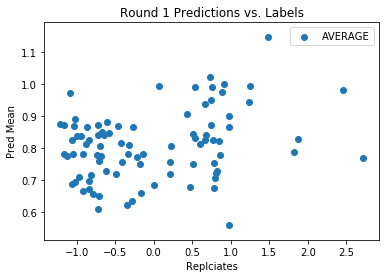

In [11]:
# plt.scatter(df_bandit2['Rep1'], df_bandit2['Pred Mean'], label = 'rep1')
# plt.scatter(df_bandit2['Rep2'], df_bandit2['Pred Mean'], label = 'rep2')
# plt.scatter(df_bandit2['Rep3'], df_bandit2['Pred Mean'], label = 'rep3')
# plt.scatter(df_bandit2['Rep4'], df_bandit2['Pred Mean'], label = 'rep4')
# plt.scatter(df_bandit2['Rep5'], df_bandit2['Pred Mean'], label = 'rep5')
plt.scatter(df_bandit2['AVERAGE'], df_bandit2['Pred Mean'], label = 'AVERAGE')
plt.xlabel('Replciates')
plt.ylabel('Pred Mean')
plt.title('Round 1 Predictions vs. Labels')
plt.legend()

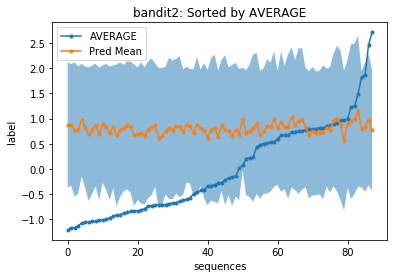

In [12]:
sorted_by_ave_df_bandit2 = df_bandit2.sort_values(by = ['AVERAGE'])
plt.plot(range(len(sorted_by_ave_df_bandit2['AVERAGE'])), sorted_by_ave_df_bandit2['AVERAGE'], label = 'AVERAGE', marker = '.')
plt.plot(range(len(sorted_by_ave_df_bandit2['AVERAGE'])), sorted_by_ave_df_bandit2['Pred Mean'], label = 'Pred Mean', marker = '.')
plt.fill_between(
                range(len(sorted_by_ave_df_bandit2['AVERAGE'])),
                sorted_by_ave_df_bandit2['Pred Mean'] + 2 * sorted_by_ave_df_bandit2['Pred Std'],
                sorted_by_ave_df_bandit2['Pred Mean'] - 2 * sorted_by_ave_df_bandit2['Pred Std'],
                alpha = 0.5
    )
plt.legend()
plt.title('bandit2: Sorted by AVERAGE')
plt.xlabel('sequences')
plt.ylabel('label')
plt.show()

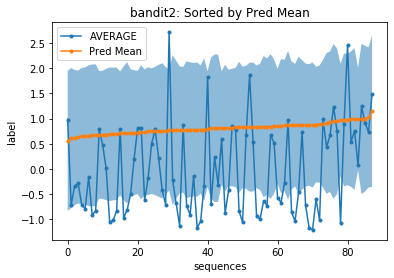

In [13]:
sorted_by_ave_df_bandit2 = df_bandit2.sort_values(by = ['Pred Mean'])
plt.plot(range(len(sorted_by_ave_df_bandit2['AVERAGE'])), sorted_by_ave_df_bandit2['AVERAGE'], label = 'AVERAGE', marker = '.')
plt.plot(range(len(sorted_by_ave_df_bandit2['AVERAGE'])), sorted_by_ave_df_bandit2['Pred Mean'], label = 'Pred Mean', marker = '.')
plt.fill_between(
                range(len(sorted_by_ave_df_bandit2['AVERAGE'])),
                sorted_by_ave_df_bandit2['Pred Mean'] + 2 * sorted_by_ave_df_bandit2['Pred Std'],
                sorted_by_ave_df_bandit2['Pred Mean'] - 2 * sorted_by_ave_df_bandit2['Pred Std'],
                alpha = 0.5
    )
plt.legend()
plt.title('bandit2: Sorted by Pred Mean')
plt.xlabel('sequences')
plt.ylabel('label')
plt.show()

## Poor Prediction? 

From the above three prediction vs true label plots, the prediction looks pretty bad, in terms of
- the predicted label looks random in the sorted AVERAGE plot.
- the 95% confidence interval fails to cover (a lot of) true labels. 

Here are some reasons this happens:
- if we look at the training set (round 1), although the highest (averaged) labels are around 2.5 (expect concensus sequence), our design on focus on the core part, so we should exclude the noncore group, then the best one is only around 1.3. Our highest prediction is around 1.2 (remember we stil have a little bit regression-to-mean). So it makes no sense we are able to predict some very high label (as the true labels show, to be around 3) given the training labels we got.
- Round 1 and 0 are from different distribution/design area. If it is true that Round 1 from the area we have no information, then the question to ask is, whether do we want such design? Evidence:
    - From [result_analysis/Prediction_compare_with_baseline.ipynb], the prediction with training from both Round 0 and 1 looks good, while the prediction from Round 0 and test on Round 1 looks bad. 
    - From [data/Clustering/] plots, the bandit2 group are not in the area where we have known information.